In [1]:
from pathlib import Path
import cv2
import dlib
import sys
import numpy as np
import argparse
from concurrent import futures
from contextlib import contextmanager
from lib.wide_resnet import WideResNet
from keras.utils import get_file
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
import json
from threading import Lock
import time

classifier = load_model("../models/video/emotion_little_vgg_2.h5")
pretrained_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.28-3.73.hdf5"

modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
emotion_classes = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}


def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)


# Define our model parameters
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

# Get our weight file
if not weight_file:
    weight_file = get_file("weights.28-3.73.hdf5", pretrained_model, cache_subdir="../models/video/",
                           file_hash=modhash, cache_dir=Path(sys.argv[0]).resolve().parent)

# Load model and weights
img_size = 64
model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(weight_file)

detector = dlib.get_frontal_face_detector()

frame_no = 0  # Initialize frame_no
frames_dict = {}
toJSON = {}
current_time_min = 0
f = open("frame_data.json", 'w+')
lock = Lock()


@contextmanager
def video_capture(*args, **kwargs):
    cap = cv2.VideoCapture(*args, **kwargs)
    try:
        yield cap
    finally:
        cap.release()


def process_frame(frame, index):
    current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
    current_time_sec = current_time_msec / 1000
    current_time_min = current_time_sec

    value = []
    preprocessed_faces_emo = []

    input_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = np.shape(input_img)
    detected = detector(frame, 1)
    faces = np.empty((len(detected), img_size, img_size, 3))

    preprocessed_faces_emo = []
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(frame[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
            face = frame[yw1:yw2 + 1, xw1:xw2 + 1, :]
            face_gray_emo = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_gray_emo = cv2.resize(face_gray_emo, (48, 48), interpolation=cv2.INTER_AREA)
            face_gray_emo = face_gray_emo.astype("float") / 255.0
            face_gray_emo = img_to_array(face_gray_emo)
            face_gray_emo = np.expand_dims(face_gray_emo, axis=0)
            preprocessed_faces_emo.append(face_gray_emo)

        # Make a prediction for Age and Gender
        results = model.predict(np.array(faces))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()

        # Make a prediction for Emotion
        emo_labels = []
        for i, d in enumerate(detected):
            preds = classifier.predict(preprocessed_faces_emo[i])[0]
            emo_labels.append(emotion_classes[preds.argmax()])

        # Draw results
        for i, d in enumerate(detected):
            label = "{}, {}, {}".format(int(predicted_ages[i]),
                                        "F" if predicted_genders[i][0] > 0.4 else "M", emo_labels[i])
            draw_label(frame, (d.left(), d.top()), label)
            value.append(label.split(', '))
            cur_frame = [index]
            cur_frame.extend(label.split(', '))
            # add start and end time
            cur_frame.append(current_time_min - 1)
            cur_frame.append(current_time_min)

            with lock:
                frames_dict[index] = cur_frame

    with lock:
        key = f"Frame:{index}"
        toJSON[key] = value


def process_video_frames():
    global frame_no  # Declare frame_no as global
    global current_time_min
    start_time = time.time()
    executor = futures.ThreadPoolExecutor()  # Create a ThreadPoolExecutor

    print(frame_no, "/", cap.get(cv2.CAP_PROP_FRAME_COUNT), end='\t')
    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of Video")
            break

        executor.submit(process_frame, frame, frame_no)  # Submit frame processing to executor

        if cv2.waitKey(1) == 13:  # 13 is the Enter Key
            break

        frame_no += 1

    executor.shutdown()  # Wait for all tasks to complete
    json_str = json.dumps(toJSON, indent=4) + '\n'
    f.write(json_str)
    f.close()
    fps_count = cap.get(cv2.CAP_PROP_FPS)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time:", elapsed_time)


with video_capture('../test_files/Malinga.mkv') as cap:
    process_video_frames()


1/1 [==============================] - ETA: 0s

In [28]:
import pandas as pd

df = pd.DataFrame.from_dict(frames_dict, orient='index', columns=['Frame', 'Age', 'Gender', 'Emotion', 'Start_Time', 'End_Time'])
sorted_df = df.sort_values('Frame', ascending=True)

# add start_time

sorted_df.to_csv('sorted_data.csv', index=False)
sorted_df


{12: [12, '36', 'M', 'Neutral', 11.0, 12.0], 13: [13, '30', 'M', 'Angry', 12.0, 13.0], 15: [15, '34', 'M', 'Angry', 14.0, 15.0], 18: [18, '34', 'M', 'Angry', 17.0, 18.0], 1: [1, '34', 'M', 'Fear', 0.0, 1.0], 21: [21, '35', 'M', 'Neutral', 20.0, 21.0], 22: [22, '35', 'M', 'Angry', 21.0, 22.0], 23: [23, '34', 'M', 'Neutral', 22.0, 23.0], 17: [17, '33', 'M', 'Fear', 16.0, 17.0], 8: [8, '33', 'M', 'Fear', 7.0, 8.0], 24: [24, '34', 'M', 'Neutral', 23.0, 24.0], 14: [14, '31', 'M', 'Sad', 13.0, 14.0], 28: [28, '36', 'M', 'Neutral', 35.0, 36.0], 25: [25, '35', 'M', 'Fear', 35.0, 36.0], 29: [29, '34', 'M', 'Fear', 35.0, 36.0], 27: [27, '40', 'M', 'Neutral', 35.0, 36.0], 34: [34, '33', 'M', 'Fear', 35.0, 36.0], 33: [33, '33', 'M', 'Sad', 35.0, 36.0], 32: [32, '37', 'M', 'Fear', 35.0, 36.0], 31: [31, '33', 'M', 'Angry', 35.0, 36.0], 30: [30, '31', 'M', 'Sad', 35.0, 36.0], 35: [35, '33', 'M', 'Fear', 35.0, 36.0], 26: [26, '33', 'M', 'Sad', 35.0, 36.0], 36: [36, '34', 'M', 'Neutral', 37.0, 38.0], 3

,Frame,Age,Gender,Emotion,Start_Time,End_Time
1,1,34,M,Fear,0.0,1.0
8,8,33,M,Fear,7.0,8.0
12,12,36,M,Neutral,11.0,12.0
13,13,30,M,Angry,12.0,13.0
14,14,31,M,Sad,13.0,14.0
...,...,...,...,...,...,...
128,128,36,M,Neutral,127.0,128.0
130,130,31,M,Neutral,129.0,130.0
131,131,33,M,Neutral,130.0,131.0
132,132,34,M,Neutral,131.0,132.0


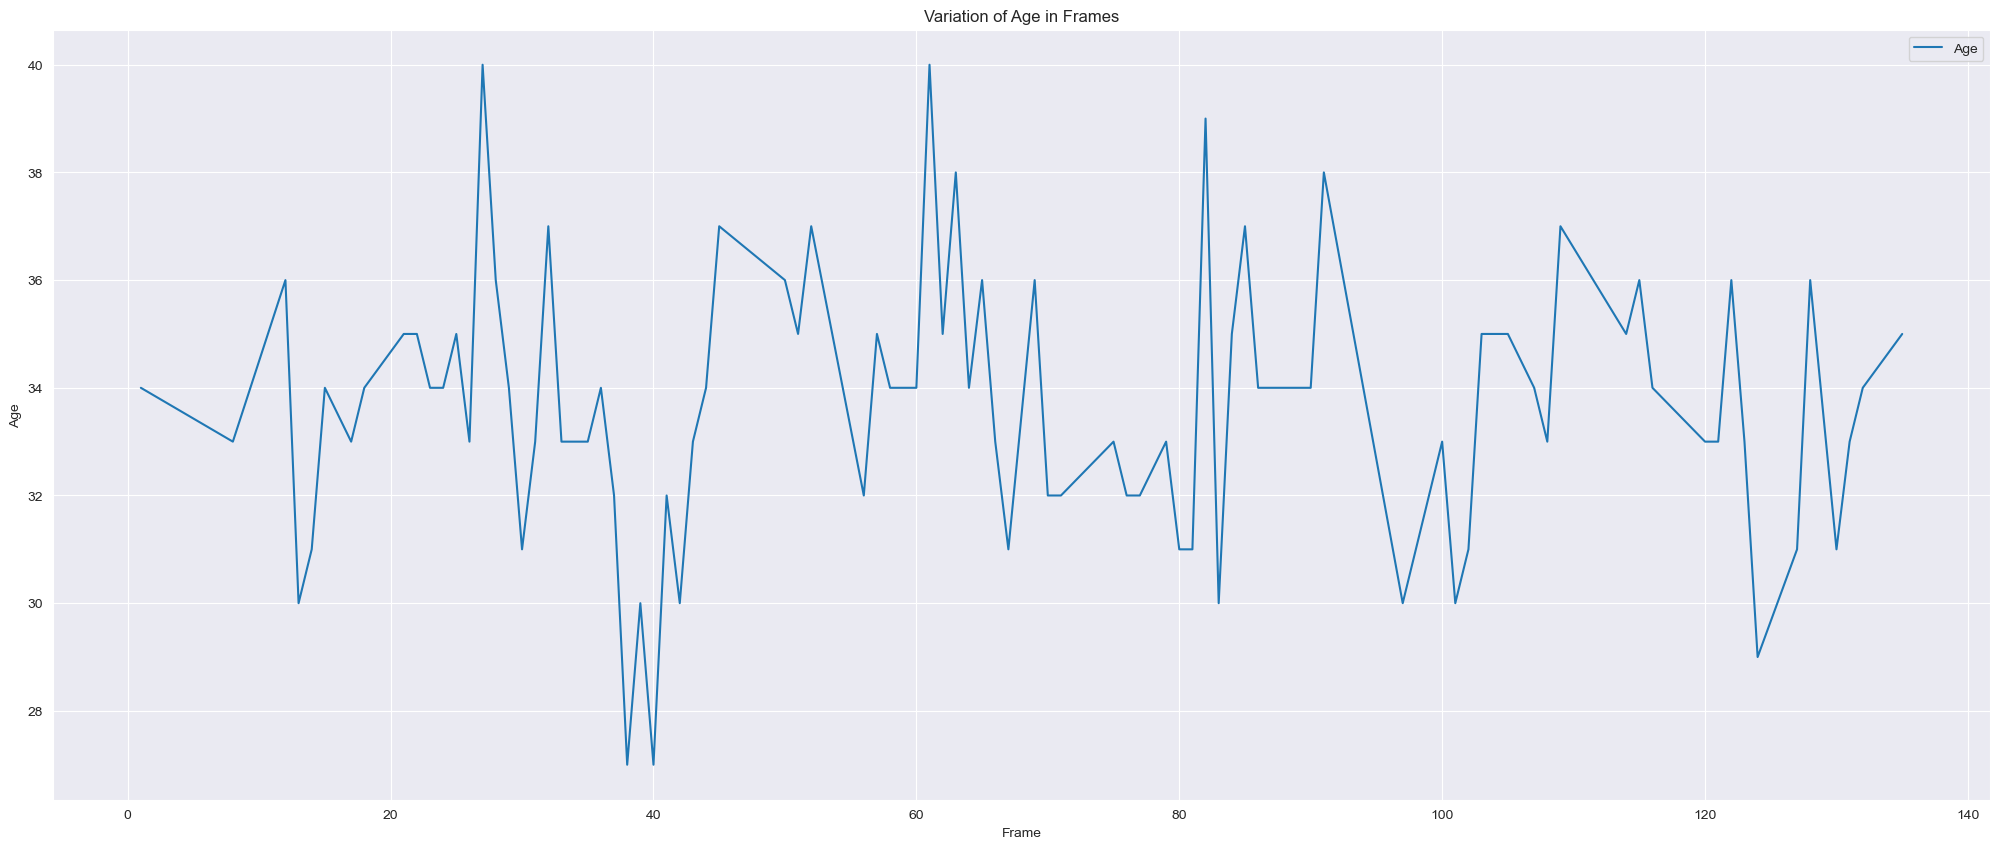

In [29]:
import matplotlib.pyplot as plt

sorted_df['Age'] = sorted_df['Age'].astype(int)
sorted_df.plot(x='Frame', y='Age', figsize=(25,10), title='Variation of Age in Frames', ylabel='Age')

plt.show()


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

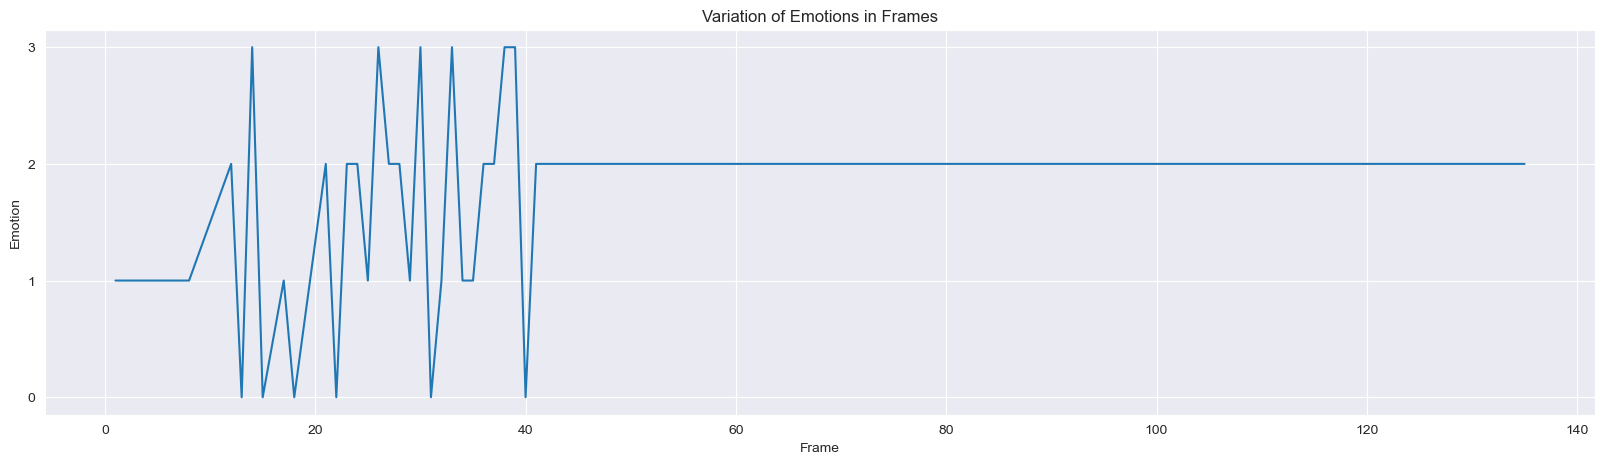

In [30]:
import matplotlib.pyplot as plt

dict_emo = sorted_df.set_index('Frame').to_dict()['Emotion']
x = np.array(list(zip(*dict_emo.items())))
u, ind = np.unique(x[1,:], return_inverse=True)
x[1,:] = ind

u, ind = np.unique(x[1,:], return_inverse=True)
x[1,:] = ind
x = x.astype(int).T
plt.figure(figsize=(20,5))
# plot the two columns of the array
plt.plot(x[:,0], x[:,1])
#set the labels accordingly
plt.gca().set_yticks(range(len(u)))
plt.title("Variation of Emotions in Frames")
plt.xlabel("Frame")
plt.ylabel("Emotion")
plt.gca().set_yticklabels(['Angry', 'Fear', 'Happy', 'Neutral', 'Sad'])
plt.tick_params(labelsize=10)
plt.show()


In [ ]:
import seaborn as sns

sns.scatterplot(data=sorted_df, x='Frame', y='Emotion', hue='Gender')
plt.title('Variation of Emotions in Frames')
plt.xlabel('Frame')
plt.ylabel('Emotion')
plt.show()
